In [131]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
weather = pd.read_csv(
    os.path.join(
        "..", "data", "AutonomousGreenhouseChallenge_edition2", "Weather", "Weather.csv"
    )
)
weather["datetime"] = pd.to_datetime(weather["%time"], unit="D", origin="1899-12-30")
weather["time_of_day"] = (
    weather["datetime"].dt.hour * 60 + weather["datetime"].dt.minute
) / 5
weather["day_of_year"] = weather["datetime"].dt.day_of_year
weather["time_sin"] = np.sin(weather["time_of_day"] * (2 * np.pi / 288))
weather["time_cos"] = np.cos(weather["time_of_day"] * (2 * np.pi / 288))
weather["day_sin"] = np.sin(weather["day_of_year"] * (2 * np.pi / 365))
weather["day_cos"] = np.cos(weather["day_of_year"] * (2 * np.pi / 365))
# weather['days_planted'] = (weather['datetime'] - pd.to_datetime('2019-10-19')).dt.days
weather["days_planted"] = (weather["datetime"] - pd.to_datetime("2019-12-16")).dt.days
# weather['days_planted'] = (weather['datetime'] - weather['datetime'].dt.min()).dt.days
weather = weather.set_index("datetime", drop=True)
weather = weather.drop(columns=["%time"])
weather = (
    weather.asfreq("5T", method="nearest").fillna(method="bfill").fillna(method="ffill")
)
weather = weather[:"2020-05-29"]

In [88]:
teams = ["AICU", "Automatoes", "Digilog", "IUACAAS", "Reference", "TheAutomators"]
temp_pred_feats = {
    "sequence_features": [
        "Tout_norm",
        "Tair_norm",
        "t_heat_sp_norm",
        "time_sin",
        "time_cos",
        "day_sin",
        "day_cos",
    ],
    "regressor_features": [
        "Tout_norm",
        "t_heat_sp_norm",
        "time_sin",
        "time_cos",
        "day_sin",
        "day_cos",
    ],
    "output_col": "Tair_norm",
}


input_width = 12
train_steps_per_epoch = (47808 - input_width + 1) * (len(teams) - 1)
val_steps_per_epoch = 47808 - input_width + 1
batch_size = 64

In [4]:
green_climate = pd.DataFrame()
for file in glob.glob(
    os.path.join(
        "..",
        "data",
        "AutonomousGreenhouseChallenge_edition2",
        "*",
        "GreenhouseClimate.csv",
    )
):
    sub_green_climate = pd.read_csv(file)
    sub_green_climate["datetime"] = pd.to_datetime(
        sub_green_climate["%time"], unit="D", origin="1899-12-30"
    )
    sub_green_climate = sub_green_climate.set_index("datetime", drop=True)
    sub_green_climate = sub_green_climate.drop(columns=["%time"])
    for col in sub_green_climate.columns:
        sub_green_climate[col] = pd.to_numeric(sub_green_climate[col], errors="coerce")
    sub_green_climate["team"] = file.split("\\")[-2]
    sub_green_climate = (
        sub_green_climate.asfreq("5T", method="nearest")
        .fillna(method="bfill")
        .fillna(method="ffill")
    )
    sub_green_climate = sub_green_climate[:"2020-05-29"]
    sub_green_climate = sub_green_climate.join(weather)
    green_climate = pd.concat([green_climate, sub_green_climate])

green_climate[["Tair_norm", "Tout_norm", "t_heat_sp_norm"]] = (
    green_climate[["Tair", "Tout", "t_heat_sp"]] / 40
)

C:\Users\user\AppData\Local\Temp\ipykernel_12112\3955846875.py:3: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  sub_green_climate = pd.read_csv(file)
C:\Users\user\AppData\Local\Temp\ipykernel_12112\3955846875.py:3: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  sub_green_climate = pd.read_csv(file)
C:\Users\user\AppData\Local\Temp\ipykernel_12112\3955846875.py:3: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  sub_green_climate = pd.read_csv(file)
C:\Users\user\AppData\Local\Temp\ipykernel_12112\3955846875.py:3: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14

In [82]:
def train_autoregressive(
    model,
    train_df,
    val_df,
    sequence_features: list[str],
    regressor_features: list[str],
    output_col: str,
    epochs=1,
):
    relevant_cols = list(
        set(sequence_features) | set(regressor_features) | set([output_col])
    ) + ["team"]
    train_dict = {}
    val_dict = {}
    train_dfs = []
    val_dfs = []

    epochs = epochs
    loss_fn = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.SGD()

    train_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    val_rmse_metric = tf.keras.metrics.RootMeanSquaredError()

    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            preds = model(x, training=True)
            loss_value = loss_fn(y, preds)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        train_rmse_metric.update_state(y, preds)
        return preds, loss_value

    @tf.function
    def test_step(x, y):
        preds = model(x, training=False)
        val_rmse_metric.update_state(y, preds)
        return preds

    for epoch in range(epochs):

        for team in train_df["team"].unique():
            loss_vals = []

            temp = (
                train_df[train_df["team"] == team][relevant_cols]
                .copy(deep=True)
                .reset_index()
            )
            temp[output_col + "_org"] = temp[output_col]
            temp.loc[input_width + 1 :, output_col] = 0
            for i in range((47808 - input_width)):
                input_1 = tf.expand_dims(
                    tf.convert_to_tensor(
                        temp[sequence_features].iloc[i : i + input_width]
                    ),
                    axis=0,
                )
                input_2 = tf.expand_dims(
                    tf.convert_to_tensor(
                        temp[regressor_features].iloc[i + input_width]
                    ),
                    axis=0,
                )
                outputs = tf.expand_dims(
                    tf.convert_to_tensor(
                        temp[output_col + "_org"].iloc[i + input_width]
                    ),
                    axis=0,
                )
                preds, loss_value = train_step(
                    {"input_1": input_1, "input_2": input_2}, outputs
                )
                loss_vals.append(loss_value)

                temp.loc[i + input_width, output_col] = preds.numpy()[0][0]

                if i % 2000 == 0:
                    print(
                        "Training loss (for one batch) at step %d: %.8f"
                        % (i, float(np.array(loss_vals).mean()))
                    )
                    print("Seen so far: %s samples" % ((i + 1) * 1))
                    loss_vals = []

            train_dfs.append(temp)

        train_rmse = train_rmse_metric.result()
        print("Training rmse over epoch: %.8f" % (float(train_rmse),))

        train_rmse_metric.reset_states()

        train_dict[epoch] = pd.concat(train_dfs, ignore_index=True)

        for team in val_df["team"].unique():

            val_temp = (
                val_df[val_df["team"] == team][relevant_cols]
                .copy(deep=True)
                .reset_index()
            )
            val_temp[output_col + "_org"] = val_temp[output_col]
            val_temp.loc[input_width + 1 :, output_col] = 0
            for i in range((47808 - input_width)):
                input_1 = tf.expand_dims(
                    tf.convert_to_tensor(
                        val_temp[sequence_features].iloc[i : i + input_width]
                    ),
                    axis=0,
                )
                input_2 = tf.expand_dims(
                    tf.convert_to_tensor(
                        val_temp[regressor_features].iloc[i + input_width]
                    ),
                    axis=0,
                )
                outputs = tf.expand_dims(
                    tf.convert_to_tensor(
                        val_temp[output_col + "_org"].iloc[i + input_width]
                    ),
                    axis=0,
                )
                preds = test_step({"input_1": input_1, "input_2": input_2}, outputs)

                val_temp.loc[i + input_width, output_col] = preds.numpy()[0][0]

            val_dfs.append(val_temp)

        val_rmse = val_rmse_metric.result()
        val_rmse_metric.reset_states()
        print("Validation rmse: %.8f" % (float(val_rmse),))
        val_dict[epoch] = pd.concat(val_dfs, ignore_index=True)

    return model, train_dict, val_dict

In [83]:
def predict_autoregressive(
    model,
    input_df,
    sequence_features: list[str],
    regressor_features: list[str],
    output_col: str,
):
    @tf.function
    def test_step(x, y):
        preds = model(x, training=False)
        return preds

    if "team" in input_df.columns:
        relevant_cols = list(
            set(sequence_features) | set(regressor_features) | set([output_col])
        ) + ["team"]
        res_dfs = []

        for team in input_df["team"].unique():

            temp = (
                input_df[input_df["team"] == team][relevant_cols]
                .copy(deep=True)
                .reset_index()
            )
            temp[output_col + "_org"] = temp[output_col]
            temp.loc[input_width + 1 :, output_col] = 0
            for i in range((47808 - input_width)):
                input_1 = tf.expand_dims(
                    tf.convert_to_tensor(
                        temp[sequence_features].iloc[i : i + input_width]
                    ),
                    axis=0,
                )
                input_2 = tf.expand_dims(
                    tf.convert_to_tensor(
                        temp[regressor_features].iloc[i + input_width]
                    ),
                    axis=0,
                )
                outputs = tf.expand_dims(
                    tf.convert_to_tensor(
                        temp[output_col + "_org"].iloc[i + input_width]
                    ),
                    axis=0,
                )
                preds = test_step({"input_1": input_1, "input_2": input_2}, outputs)

                temp.loc[i + input_width, output_col] = preds.numpy()[0][0]

            res_dfs.append(temp)

        return pd.concat(res_dfs, ignore_index=True)

    else:
        relevant_cols = list(
            set(sequence_features) | set(regressor_features) | set([output_col])
        )

        temp = input_df[relevant_cols].copy(deep=True).reset_index()
        temp[output_col + "_org"] = temp[output_col]
        temp.loc[input_width + 1 :, output_col] = 0
        for i in range((47808 - input_width)):
            input_1 = tf.expand_dims(
                tf.convert_to_tensor(temp[sequence_features].iloc[i : i + input_width]),
                axis=0,
            )
            input_2 = tf.expand_dims(
                tf.convert_to_tensor(temp[regressor_features].iloc[i + input_width]),
                axis=0,
            )
            outputs = tf.expand_dims(
                tf.convert_to_tensor(temp[output_col + "_org"].iloc[i + input_width]),
                axis=0,
            )
            preds = test_step({"input_1": input_1, "input_2": input_2}, outputs)

            temp.loc[i + input_width, output_col] = preds.numpy()[0][0]

        return temp

In [138]:
def make_dense_model(
    sequence_features_len: int, regressor_features_len: int, model_name="Dense_model"
):
    input_1 = tf.keras.layers.Input(
        shape=(input_width, sequence_features_len), name="input_1"
    )
    input_2 = tf.keras.layers.Input(shape=(regressor_features_len,), name="input_2")
    flatten = tf.keras.layers.Flatten()(input_1)
    concat = tf.keras.layers.Concatenate()([flatten, input_2])
    x = tf.keras.layers.Dropout(0.05)(concat)
    x = tf.keras.layers.Dense(
        128,
        activation="relu",
    )(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    outputs = tf.keras.layers.Dense(1, activation="relu")(x)

    dense_model = tf.keras.Model(
        inputs={"input_1": input_1, "input_2": input_2},
        outputs=outputs,
        name=model_name,
    )
    return dense_model


def make_conv_model(
    sequence_features_len: int, regressor_features_len: int, model_name="Conv_model"
):
    input_1 = tf.keras.layers.Input(
        shape=(input_width, sequence_features_len), name="input_1"
    )
    input_2 = tf.keras.layers.Input(shape=(regressor_features_len,), name="input_2")
    conv_1 = tf.keras.layers.Conv1D(64, 3, activation='relu')(input_1)
    conv_2 = tf.keras.layers.Conv1D(64, 3, activation='relu')(conv_1)
    flatten = tf.keras.layers.Flatten()(conv_2)
    concat = tf.keras.layers.Concatenate()([flatten, input_2])
    x = tf.keras.layers.Dropout(0.05)(concat)
    x = tf.keras.layers.Dense(
        64,
        activation="relu",
    )(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    outputs = tf.keras.layers.Dense(1, activation="relu")(x)

    conv_model = tf.keras.Model(
        inputs={"input_1": input_1, "input_2": input_2},
        outputs=outputs,
        name=model_name,
    )
    return conv_model


def make_gru_model(
    sequence_features_len: int, regressor_features_len: int, model_name="GRU_model"
):
    input_1 = tf.keras.layers.Input(
        shape=(input_width, sequence_features_len), name="input_1"
    )
    input_2 = tf.keras.layers.Input(shape=(regressor_features_len,), name="input_2")
    gru_1 = tf.keras.layers.GRU(64, return_sequences=True, )(input_1)
    gru_2 = tf.keras.layers.GRU(64)(gru_1)
    concat = tf.keras.layers.Concatenate()([gru_2, input_2])
    x = tf.keras.layers.Dropout(0.05)(concat)
    x = tf.keras.layers.Dense(
        64,
        activation="relu",
    )(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    outputs = tf.keras.layers.Dense(1, activation="relu")(x)

    gru_model = tf.keras.Model(
        inputs={"input_1": input_1, "input_2": input_2},
        outputs=outputs,
        name=model_name,
    )
    return gru_model

# Temperature

Model: "Dense_model_temp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 7)]      0           []                               
                                                                                                  
 flatten_17 (Flatten)           (None, 84)           0           ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 concatenate_18 (Concatenate)   (None, 90)           0           ['flatten_17[0][0]',             
                                                                  'input_2[0][0]'] 

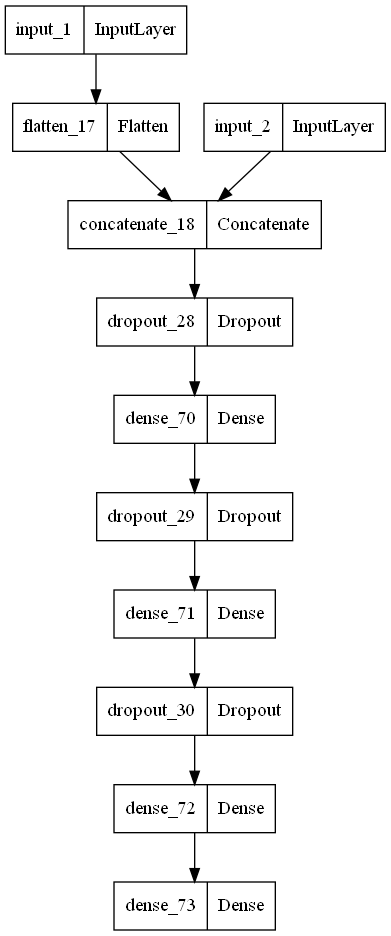

In [99]:
dense_model_temp = make_dense_model(
    sequence_features_len=len(temp_pred_feats["sequence_features"]),
    regressor_features_len=len(temp_pred_feats["regressor_features"]),
    model_name="Dense_model_temp",
)
dense_model_temp.summary()
tf.keras.utils.plot_model(model=dense_model_temp, to_file="dense_model_temp.png")

In [101]:
train_df = green_climate[
    green_climate["team"].isin(
        ["AICU", "Automatoes", "Digilog", "IUACAAS", "Reference"]
    )
]
val_df = green_climate[green_climate["team"] == "TheAutomators"]

dense_model_temp, train_dict_dense_temp, val_dict_dense_temp = train_autoregressive(
    model=dense_model_temp,
    train_df=train_df,
    val_df=val_df,
    sequence_features=temp_pred_feats["sequence_features"],
    regressor_features=temp_pred_feats["regressor_features"],
    output_col=temp_pred_feats["output_col"],
)

Training loss (for one batch) at step 0: 0.27300623
Seen so far: 1 samples
Training loss (for one batch) at step 2000: 0.01825372
Seen so far: 2001 samples
Training loss (for one batch) at step 4000: 0.00299261
Seen so far: 4001 samples
Training loss (for one batch) at step 6000: 0.00182069
Seen so far: 6001 samples
Training loss (for one batch) at step 8000: 0.00130062
Seen so far: 8001 samples
Training loss (for one batch) at step 10000: 0.00138096
Seen so far: 10001 samples
Training loss (for one batch) at step 12000: 0.00113479
Seen so far: 12001 samples
Training loss (for one batch) at step 14000: 0.00144533
Seen so far: 14001 samples
Training loss (for one batch) at step 16000: 0.00166788
Seen so far: 16001 samples
Training loss (for one batch) at step 18000: 0.00123259
Seen so far: 18001 samples
Training loss (for one batch) at step 20000: 0.00129201
Seen so far: 20001 samples
Training loss (for one batch) at step 22000: 0.00102309
Seen so far: 22001 samples
Training loss (for o

<AxesSubplot: xlabel='datetime', ylabel='value'>

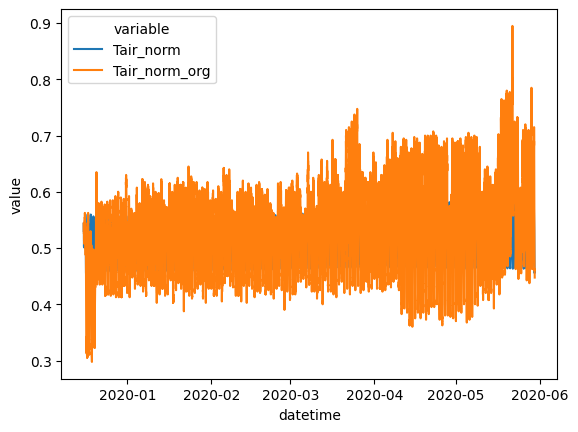

In [102]:
sns.lineplot(
    data=val_dict_dense_temp[0].melt(
        id_vars=["datetime"], value_vars=["Tair_norm", "Tair_norm_org"]
    ),
    x="datetime",
    y="value",
    hue="variable",
)

In [103]:
if not os.path.exists(os.path.join("..", "models")):
    os.mkdir(os.path.join("..", "models"))

dense_model_temp.save(os.path.join("..", "models", "dense_model_temp.h5"))

Model: "Conv_model_temp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 7)]      0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 10, 64)       1408        ['input_1[0][0]']                
                                                                                                  
 conv1d_5 (Conv1D)              (None, 8, 64)        12352       ['conv1d_4[0][0]']               
                                                                                                  
 flatten_19 (Flatten)           (None, 512)          0           ['conv1d_5[0][0]']               
                                                                                    

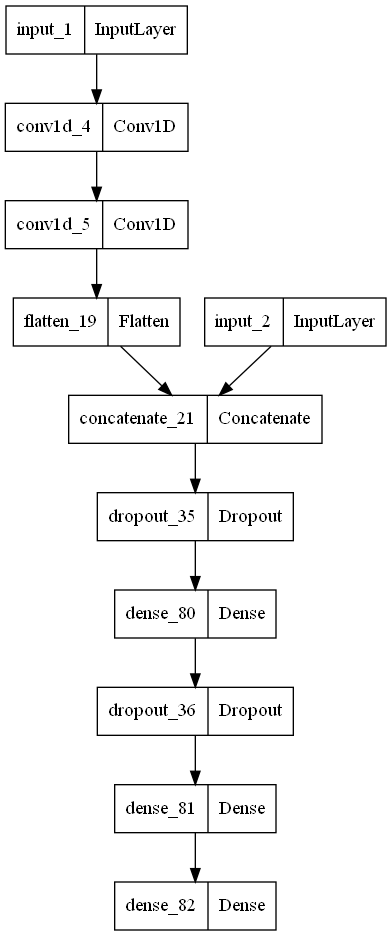

In [139]:
conv_model_temp = make_conv_model(
    sequence_features_len=len(temp_pred_feats["sequence_features"]),
    regressor_features_len=len(temp_pred_feats["regressor_features"]),
    model_name="Conv_model_temp",
)
conv_model_temp.summary()
tf.keras.utils.plot_model(model=conv_model_temp, to_file="conv_model_temp.png")

In [140]:
train_df = green_climate[
    green_climate["team"].isin(
        ["AICU", "Automatoes", "Digilog", "IUACAAS", "Reference"]
    )
]
val_df = green_climate[green_climate["team"] == "TheAutomators"]

conv_model_temp, train_dict_conv_temp, val_dict_conv_temp = train_autoregressive(
    model=conv_model_temp,
    train_df=train_df,
    val_df=val_df,
    sequence_features=temp_pred_feats["sequence_features"],
    regressor_features=temp_pred_feats["regressor_features"],
    output_col=temp_pred_feats["output_col"],
)

Training loss (for one batch) at step 0: 0.27300623
Seen so far: 1 samples
Training loss (for one batch) at step 2000: 0.00428150
Seen so far: 2001 samples
Training loss (for one batch) at step 4000: 0.00088911
Seen so far: 4001 samples
Training loss (for one batch) at step 6000: 0.00052857
Seen so far: 6001 samples
Training loss (for one batch) at step 8000: 0.00041746
Seen so far: 8001 samples
Training loss (for one batch) at step 10000: 0.00052645
Seen so far: 10001 samples
Training loss (for one batch) at step 12000: 0.00039239
Seen so far: 12001 samples
Training loss (for one batch) at step 14000: 0.00059476
Seen so far: 14001 samples
Training loss (for one batch) at step 16000: 0.00080710
Seen so far: 16001 samples
Training loss (for one batch) at step 18000: 0.00048168
Seen so far: 18001 samples
Training loss (for one batch) at step 20000: 0.00061770
Seen so far: 20001 samples
Training loss (for one batch) at step 22000: 0.00035012
Seen so far: 22001 samples
Training loss (for o

<AxesSubplot: xlabel='datetime', ylabel='value'>

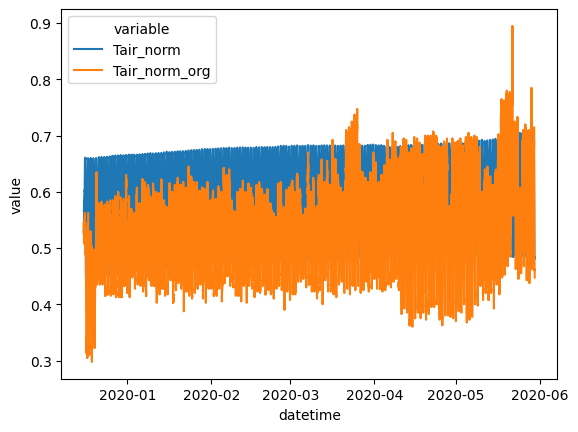

In [141]:
sns.lineplot(
    data=val_dict_conv_temp[0].melt(
        id_vars=["datetime"], value_vars=["Tair_norm", "Tair_norm_org"]
    ),
    x="datetime",
    y="value",
    hue="variable",
)

In [142]:
if not os.path.exists(os.path.join("..", "models")):
    os.mkdir(os.path.join("..", "models"))

conv_model_temp.save(os.path.join("..", "models", "conv_model_temp.h5"))

Model: "Conv_model_temp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 7)]      0           []                               
                                                                                                  
 gru_2 (GRU)                    (None, 12, 64)       14016       ['input_1[0][0]']                
                                                                                                  
 gru_3 (GRU)                    (None, 64)           24960       ['gru_2[0][0]']                  
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                    

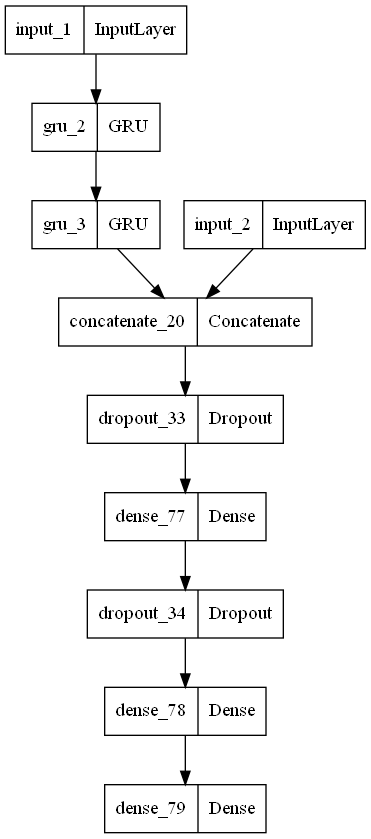

In [109]:
gru_model_temp = make_gru_model(
    sequence_features_len=len(temp_pred_feats["sequence_features"]),
    regressor_features_len=len(temp_pred_feats["regressor_features"]),
    model_name="Conv_model_temp",
)

gru_model_temp.summary()
tf.keras.utils.plot_model(model=gru_model_temp, to_file="gru_model_temp.png")

In [110]:
train_df = green_climate[
    green_climate["team"].isin(
        ["AICU", "Automatoes", "Digilog", "IUACAAS", "Reference"]
    )
]
val_df = green_climate[green_climate["team"] == "TheAutomators"]

gru_model_temp, train_dict_gru_temp, val_dict_gru_temp = train_autoregressive(
    model=gru_model_temp,
    train_df=train_df,
    val_df=val_df,
    sequence_features=temp_pred_feats["sequence_features"],
    regressor_features=temp_pred_feats["regressor_features"],
    output_col=temp_pred_feats["output_col"],
)

Training loss (for one batch) at step 0: 0.24267463
Seen so far: 1 samples
Training loss (for one batch) at step 2000: 0.00404337
Seen so far: 2001 samples
Training loss (for one batch) at step 4000: 0.00119686
Seen so far: 4001 samples
Training loss (for one batch) at step 6000: 0.00082769
Seen so far: 6001 samples
Training loss (for one batch) at step 8000: 0.00065943
Seen so far: 8001 samples
Training loss (for one batch) at step 10000: 0.00073128
Seen so far: 10001 samples
Training loss (for one batch) at step 12000: 0.00059899
Seen so far: 12001 samples
Training loss (for one batch) at step 14000: 0.00079856
Seen so far: 14001 samples
Training loss (for one batch) at step 16000: 0.00100567
Seen so far: 16001 samples
Training loss (for one batch) at step 18000: 0.00070111
Seen so far: 18001 samples
Training loss (for one batch) at step 20000: 0.00084097
Seen so far: 20001 samples
Training loss (for one batch) at step 22000: 0.00058240
Seen so far: 22001 samples
Training loss (for o

<AxesSubplot: xlabel='datetime', ylabel='value'>

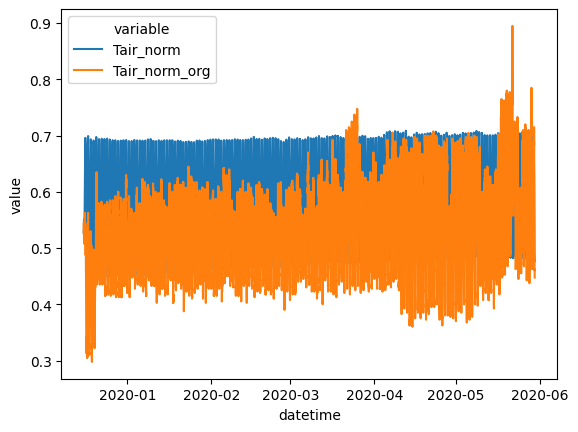

In [111]:
sns.lineplot(
    data=val_dict_gru_temp[0].melt(
        id_vars=["datetime"], value_vars=["Tair_norm", "Tair_norm_org"]
    ),
    x="datetime",
    y="value",
    hue="variable",
)

In [112]:
if not os.path.exists(os.path.join("..", "models")):
    os.mkdir(os.path.join("..", "models"))

gru_model_temp.save(os.path.join("..", "models", "gru_model_temp.h5"))